**MLP классификатор** 

Евгений Борисов  <esborisov@sevsu.ru>

О методах обучения многослойных нейронных сетей прямого распространения.    
http://mechanoid.su/neural-net-backprop.html  
http://mechanoid.su/neural-net-backprop2.html

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 1500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

# from sklearn.datasets import make_moons
# X,target = make_moons(n_samples=n_samples, noise=.09)

from sklearn.datasets import make_circles
X,target = make_circles(n_samples=n_samples, shuffle=True, noise=.09, factor=.3)
# X = X+(np.random.rand(X.shape[0],X.shape[1])*0.6)


y = np.eye(len(target),2)[target] # [:,np.newaxis]

X.shape, y.shape

((1500, 2), (1500, 2))

In [4]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750, 2), (750, 2), (750, 2))

In [7]:
del X
del y
del target

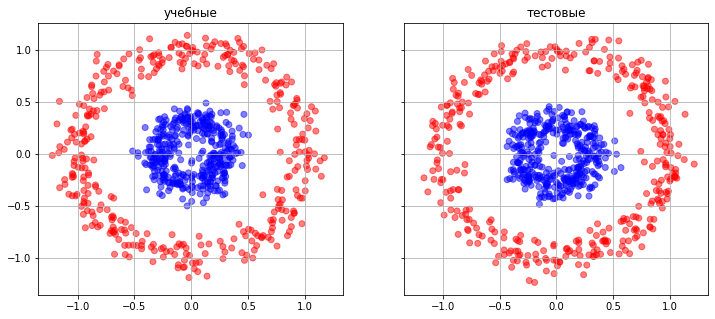

In [8]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.astype(int).flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train[:,0],'учебные')    
plot_data(ax1,X_test,y_test[:,0],'тестовые')    
plt.show()

## модель

схема нейрона

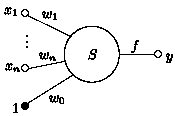

схема MPL 

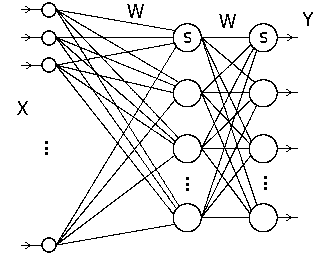

In [9]:
def state(x,w,b): # состояние нейронов
    return x.dot(w) + b

In [10]:
def sigmoid(u): # функция активации
    return 1./(1. + np.exp(-u))

In [11]:
def d_sigmoid(u): # производная активации
    return ( np.square(sigmoid(u))*np.exp(-u) )

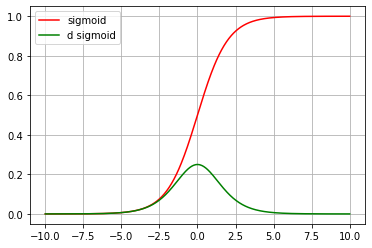

In [12]:
u=np.linspace(-10,10,500)
plt.plot( u,sigmoid(u),'-r', label='sigmoid' )
plt.plot( u,d_sigmoid(u),'-g', label='d sigmoid' )
plt.grid()
plt.legend()

In [13]:
def layer(x,w,b): # выход слоя
    return sigmoid( state( x,w,b) )

In [15]:
def score(x,weight): # выход сети
    o = x
    for w,b in weight:
        o = layer(o,w,b)
    return o

In [ ]:
# инициализация параметров сети
def weight_init(size):
    return [ 
        [ 
            rng.normal(size=(size[i],size[i+1]),scale=.1), 
            rng.normal(size=(1,size[i+1]),scale=.1) 
        ]
       for i in range(len(size)-1) 
    ]

In [14]:
size = [ # размеры сети
    X_train.shape[1], # нулевой - распределительный/входной слой
    10, # первый - обрабатывающий/скрытый слой
    5, # второй - обрабатывающий/скрытый слой
    y_train.shape[1], # третий - обрабатывающий/выходной слой
]

weight = weight_init(size) # инициализация весов и сдвигов всех нейронов сети

## обучаем модель

функция потери средняя квадратичная ошибка
$$L=MSQE(y,o)=\frac{1}{m}\sum\limits_{i=0}^m(o_i-y_i)^2$$

In [43]:
def msqe(y,o): # функция потери - средняя квадратичная ошибка
    return np.square(o-y).sum()/(len(y)*y.shape[1])

loss = msqe

In [42]:
# msqe(y_train,score(X_train,weight))

градиент функции потери - частные производные по всем параметрам модели, направление наискорейшего возрастания функции 

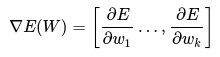


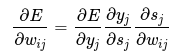

процедура обратного распространения ошибки

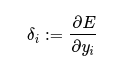

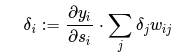

In [19]:
def forward(x,weight): # прямой проход
    layers_state = []
    layers_output = []
    o = x
    for w,b in weight:
        s = state(o,w,b)
        layers_state.append(s)
        o = sigmoid(s)
        layers_output.append(o)
    return (
        layers_state, # состояние слоёв сети
        layers_output # выходы слоёв сети
    )

In [20]:
def backward(d_output,layers_state,weight): # обратный проход
    delta = [ d_output ]
    d = d_output
    for s,(w,b) in zip( 
        layers_state[:-1][::-1], # выкинуть последний, список в обратном порядке
        weight[1:][::-1]  # выкинуть первый, список в обратном порядке
    ):
        d = d_sigmoid(s)*d.dot(w.T)
        delta.append(d)
    return delta[::-1] # значение ошибки для всех нейронов скрытых слоёв

In [ ]:
def weight_norm(weight): # нормируем значения градиента
    w_max = max([ np.abs(np.hstack([w.flatten(),b.flatten()])).max() for w,b in weight ])
    if w_max>0.: return [ [w/w_max,b/w_max] for w,b in weight ]
    return weight

In [22]:
def msqe_partial(x,weight,y): # градиент функции потери
    layers_state, layers_output = forward(x,weight) # состояния и выходы всех нейронов сети
    d_output = (layers_output[-1]-y)* d_sigmoid(layers_state[-1]) # ошибка выходного слоя
    delta = backward(d_output,layers_state,weight) # значение ошибки для всех нейронов скрытых слоёв
    
    d_weight = [ # значения градиента для всех параметров (весов и сдвигов) сети
        [ 
          x.T.dot(d), # градиент для матрицы весов слоя
          d.sum(axis=0,keepdims=True), # # градиент для вектора сдвигов слоя
        ]
        for x,d in zip( [x]+layers_output[:-1], delta ) 
        ]
    
    return weight_norm(d_weight) # нормируем значения градиента

gradient = msqe_partial

# msqe_partial(X_train,weight,y_train)

In [27]:
# корректируем параметры
def weight_adjust(weight,d_weight,lr):
    return [ 
        [ w-lr*dw, b-lr*db ]  
        for (w,b),(dw,db) in zip(weight,d_weight) 
    ]

In [28]:
def fit_epoch(x,weight,y,lr): # шаг обучения модели
    d_weight = gradient(x,weight,y) # градиент функции потери, изменение весов
    return weight_adjust(weight,d_weight,lr) # корректируем параметры

In [29]:
from sklearn.metrics import accuracy_score

In [31]:
%%time

# метод градиентного спуска

lr = 5e-2 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 2000 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = X_train.shape[1] # размер вектора признаков

# начальное значение ф-ции потери
loss_history = [ loss(y_train,score(X_train,weight)) ]
acc_history = [ accuracy_score( y_train[:,1].astype(int), (score(X_train,weight)[:,1]>.5).astype(int) ) ]

for i in range(n_epoch): # цикл обучения
    weight = fit_epoch(X_train,weight,y_train,lr) # корректируем веса модели
    loss_history.append( loss(y_train,score(X_train,weight)) ) # считаем значение ф-ции потери
    acc_history.append( accuracy_score( y_train[:,1].astype(int) , (score(X_train,weight)[:,1]>.5).astype(int) ) )
    
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

step 815/2000: loss 0.024, acc threshold 0.980 reached

CPU times: user 721 ms, sys: 0 ns, total: 721 ms
Wall time: 721 ms


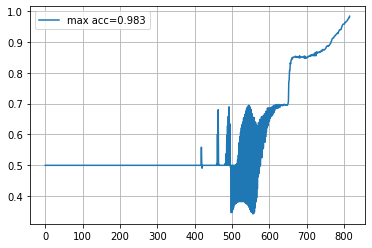

In [32]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)))
plt.grid()
plt.legend()

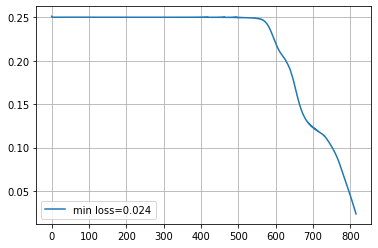

In [33]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [35]:
s = score(X_test,weight)[:,1]

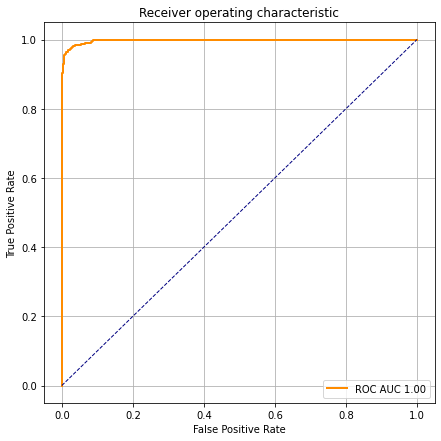

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test[:,1], s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [37]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

0.661892872703097

In [38]:
p = (s>optimal_threshold).astype(int)
y = y_test[:,1].astype(int)

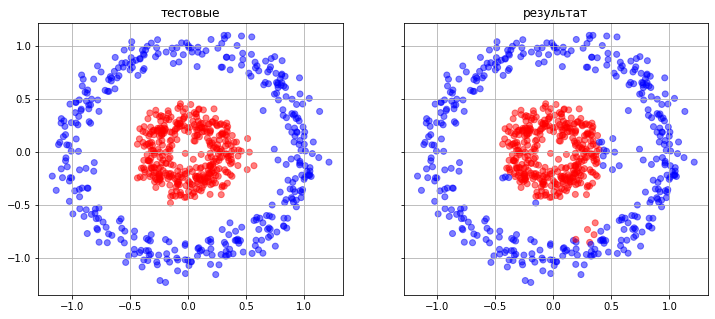

In [39]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       375
           1       0.99      0.96      0.97       375

    accuracy                           0.97       750
   macro avg       0.97      0.97      0.97       750
weighted avg       0.97      0.97      0.97       750



## карта скоров

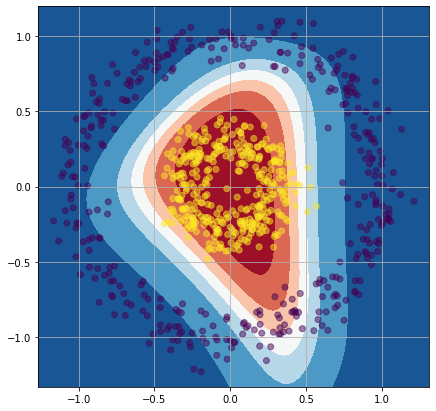

In [41]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=500 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 

s = score(xy,weight)[:,1]

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test[:,1].astype(int), alpha=.5 )
plt.grid()